In [1]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=True
DATADIR = "/DATA" if in_container else "/BEE/Connectome/ABCD/"
raw_data_path = "/BEE/CamCAN/Download/cc700/mri/pipeline/release004/BIDS_20190411/anat"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/camcan/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [2]:
if not in_container:
    %ls $raw_data_path | wc -l

    # sub-CC[0-9]
    img_paths = glob.glob(f"{raw_data_path}/sub-CC[0-9]*/anat/*_T1w.nii.gz")
    len(img_paths)

    img = ants.image_read(img_paths[0])
    img

    img.plot()

In [3]:
%ls -ailh $processed_data_path | grep CAMCAN | head

19334285589 -rw-r--r--.  1 amahmood 1001 9.5M Nov  7 16:32 CAMCANCC110033.nii.gz
19334285590 -rw-r--r--.  1 amahmood 1001 9.3M Nov  7 16:33 CAMCANCC110037.nii.gz
19334285591 -rw-r--r--.  1 amahmood 1001 9.4M Nov  7 16:34 CAMCANCC110045.nii.gz
19334285592 -rw-r--r--.  1 amahmood 1001 8.7M Nov  7 16:36 CAMCANCC110056.nii.gz
19334285593 -rw-r--r--.  1 amahmood 1001  11M Nov  7 16:37 CAMCANCC110062.nii.gz
19334285594 -rw-r--r--.  1 amahmood 1001 9.4M Nov  7 16:38 CAMCANCC110069.nii.gz
19334285595 -rw-r--r--.  1 amahmood 1001 8.7M Nov  7 16:39 CAMCANCC110087.nii.gz
19334285596 -rw-r--r--.  1 amahmood 1001  11M Nov  7 16:41 CAMCANCC110098.nii.gz
19334285597 -rw-r--r--.  1 amahmood 1001  11M Nov  7 16:42 CAMCANCC110101.nii.gz
19334285598 -rw-r--r--.  1 amahmood 1001 9.9M Nov  7 16:43 CAMCANCC110126.nii.gz
grep: write error: Broken pipe
ls: write error


In [4]:
# dirs = glob.glob(f"{raw_data_path}/*/*")
# ages = [p.split("/")[-1] for p in dirs]
# Counter(ages)

### No WM segmentations, so heuristic

In [5]:
img_paths = glob.glob(f"{processed_data_path}/CAMCANCC[0-9]*.nii.gz")
subids = [re.search(r"(CAMCANCC\d*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(653,
 '//DATA/Users/amahmood/braintyp/camcan/CAMCANCC110033.nii.gz',
 'CAMCANCC110033')

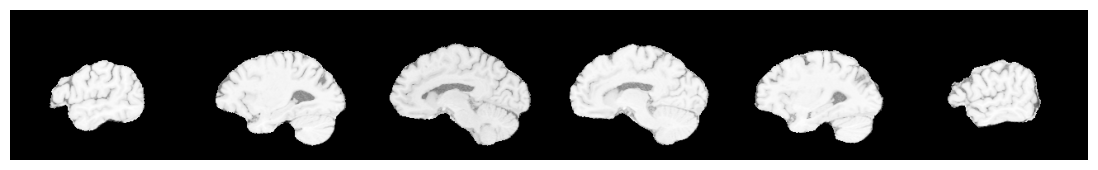

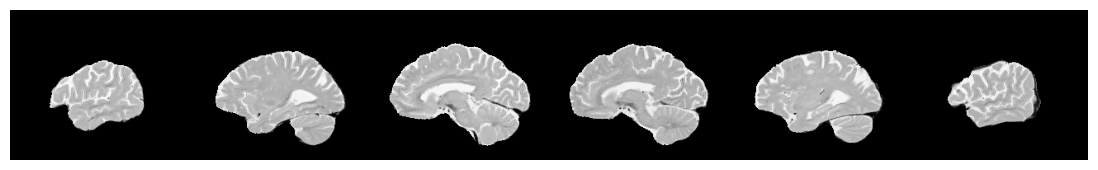

In [6]:
t1, t2 = ants.image_read(img_paths[-1]).split_channels()
t1.plot(nslices=6)
t2.plot(nslices=6)

In [7]:
t1_wm_means = pd.Series(img_paths, index=subids)
t1_wm_means.iloc[:3]

CAMCANCC110033    //DATA/Users/amahmood/braintyp/camcan/CAMCANCC...
CAMCANCC110037    //DATA/Users/amahmood/braintyp/camcan/CAMCANCC...
CAMCANCC110045    //DATA/Users/amahmood/braintyp/camcan/CAMCANCC...
dtype: object

In [8]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 653/653 [10:08<00:00,  1.07it/s]

CPU times: user 8min 4s, sys: 16 s, total: 8min 20s
Wall time: 10min 8s


In [9]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

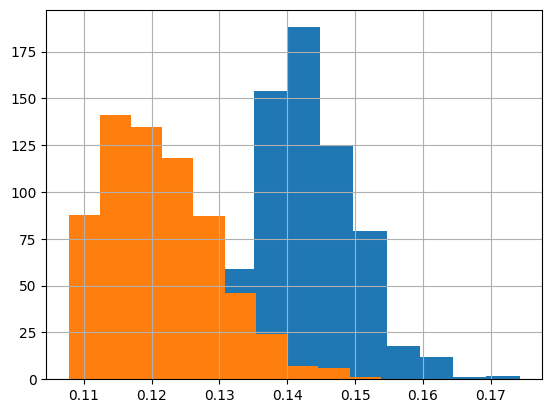

In [13]:
t1_wm_means.hist()
t2_wm_means.hist()

In [14]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

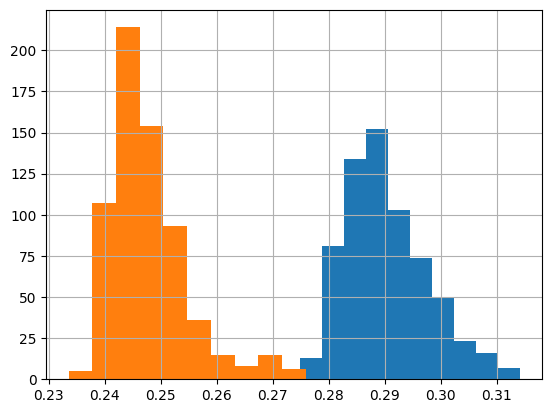

In [15]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [16]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.143 w/ std 0.007


In [17]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.290 w/ std 0.007


In [18]:
mult = 3.5
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

2

In [19]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

653

CAMCANCC120764: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC120764.nii.gz


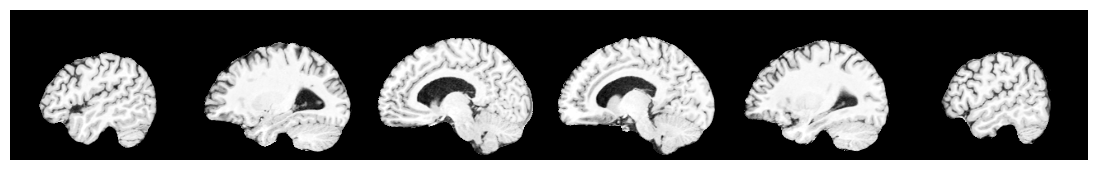

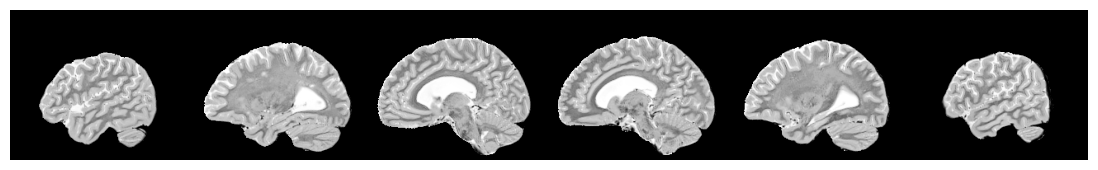

CAMCANCC121685: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC121685.nii.gz


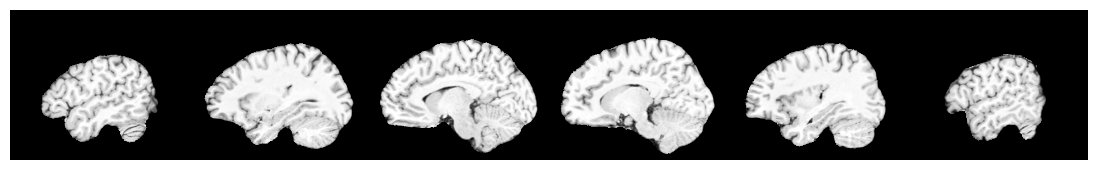

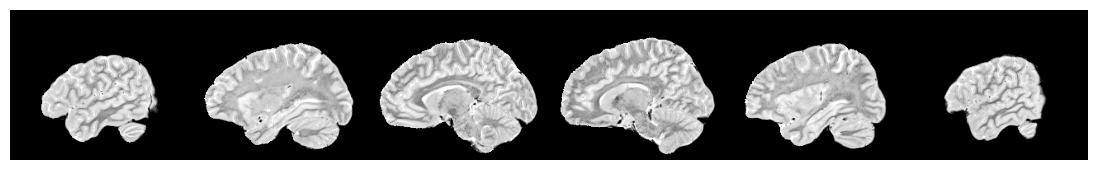

In [20]:
for tidx in t1_outliers[:4]:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [21]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [22]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.121 w/ std 0.008


In [23]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.248 w/ std 0.007


In [24]:
mult = 3.5
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

7

CAMCANCC110174: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC110174.nii.gz


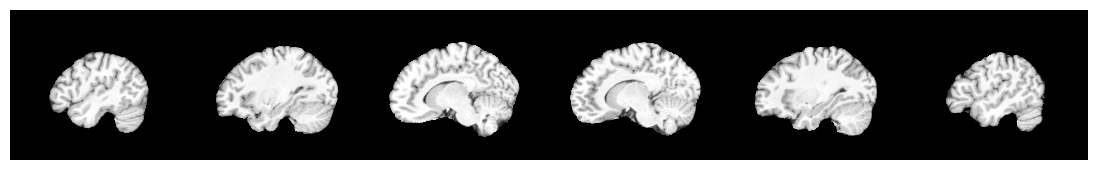

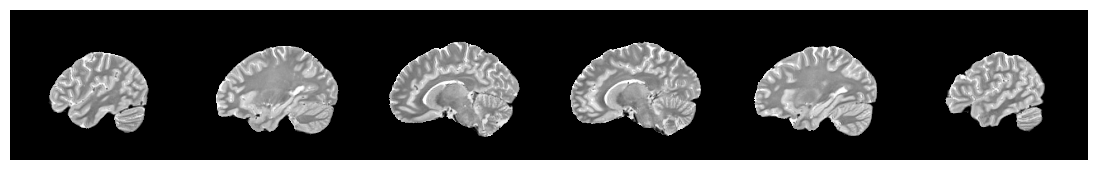

CAMCANCC221740: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC221740.nii.gz


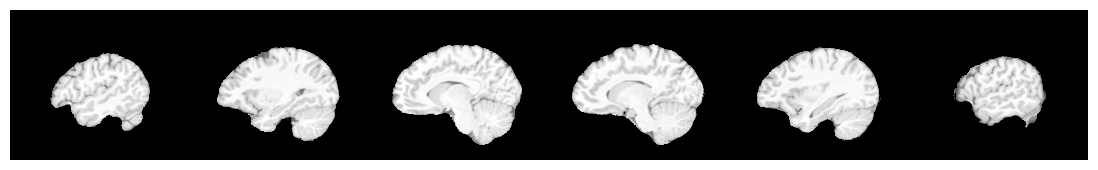

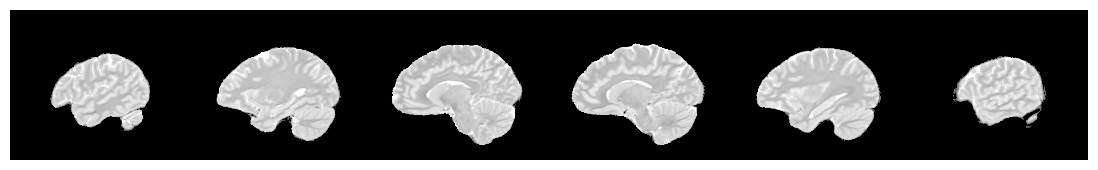

CAMCANCC320850: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC320850.nii.gz


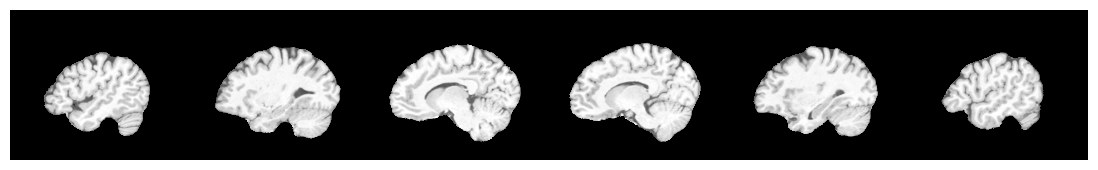

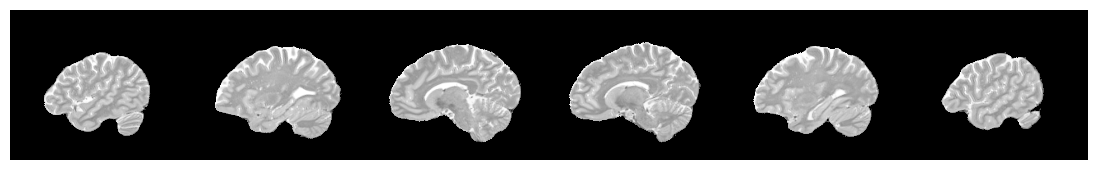

CAMCANCC510433: //DATA/Users/amahmood/braintyp/camcan//CAMCANCC510433.nii.gz


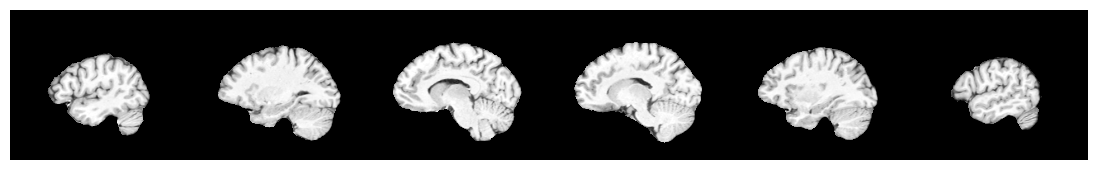

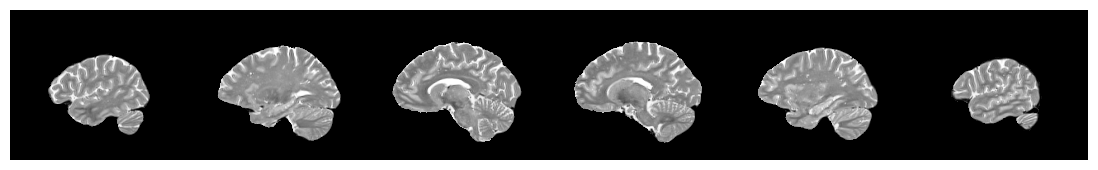

In [25]:
for tidx in t2_outliers[:4]:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

In [26]:
t1_drop_samples = t1_wm_means.index[t1_outliers].to_list()
t2_drop_samples = t2_wm_means.index[t2_outliers].to_list()
drop_samples = set(t1_drop_samples).union(set(t2_drop_samples))
len(drop_samples)

9

In [10]:
len(t1_wm_means)

653

In [11]:
cam_passing_keys = pd.Series(t1_wm_means.dropna().index).sort_values()
cam_passing_keys.to_csv('../split-keys/camcan_keys.txt', header=None, index=None)

In [13]:
val_num_samples = int(0.05 * len(cam_passing_keys))
cam_passing_keys_val = cam_passing_keys[:val_num_samples]
cam_passing_keys_train = cam_passing_keys[val_num_samples:]
cam_passing_keys_val.to_csv('../split-keys/camcan-val_keys.txt', header=None, index=None)
cam_passing_keys_train.to_csv('../split-keys/camcan-train_keys.txt', header=None, index=None)

In [14]:
val_num_samples

32

In [12]:
%%bash
cp ../split-keys/abcd-val_keys.txt ../split-keys/camcan-test_keys.txt
cat ../split-keys/hcp_keys.txt >> ../split-keys/camcan_keys.txt